In [2]:
import scanpy as sc
import anndata
import os
import fnmatch
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
#import scrublet as scr
import importlib
import sys
from harmony import harmonize
import seaborn as sns
from matplotlib import rcParams
import math
from scipy import stats
import seaborn as sns
import scipy as sp
import h5py
import warnings
import random
import math
import scvelo as scv
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

In [3]:
#Setting Scanpy figure parameters 
sc.settings.set_figure_params(dpi = 500, color_map = 'RdPu', dpi_save = 500)

In [5]:
adata = sc.read_h5ad("./Scanpy_H5AD/adata_CellBender_Scrublet_Srubed_for_publication.h5ad")
adata

AnnData object with n_obs × n_vars = 122621 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
sum(adata.obs.Doublet)

34261

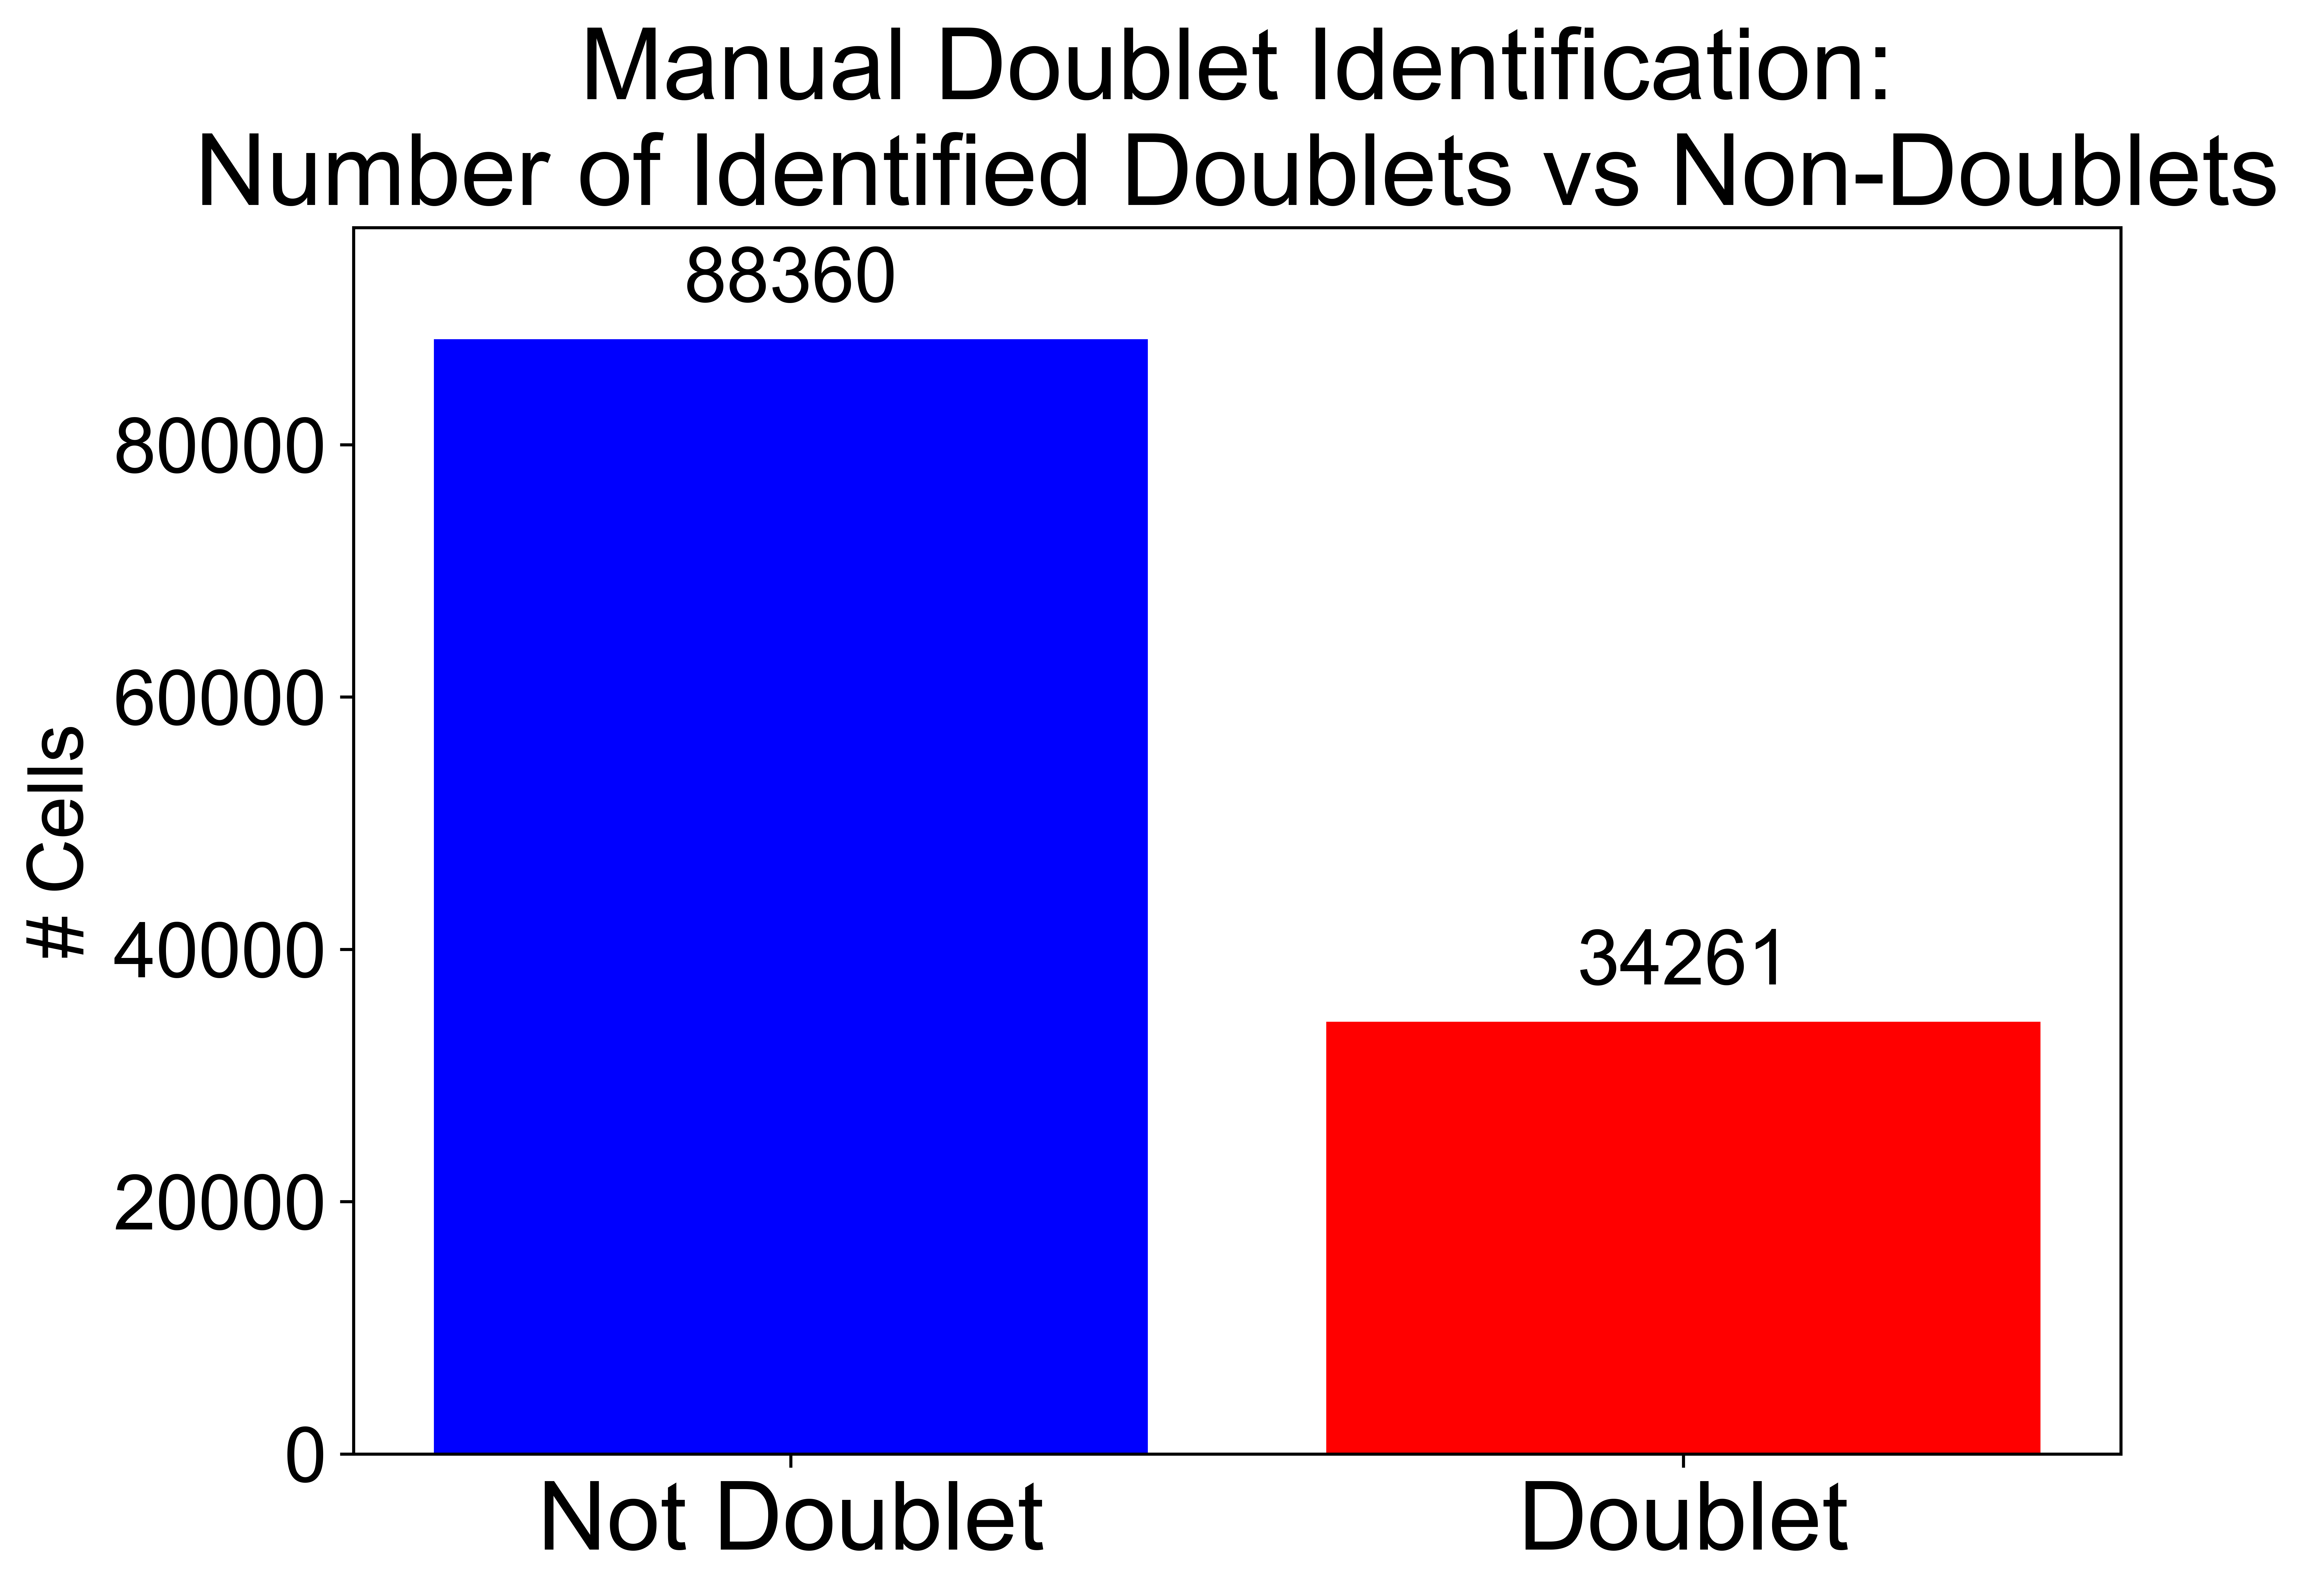

In [12]:
plt.figure(figsize=(8, 6))
# number of doublets and non-doublets
doublet_counts = adata.obs['Doublet'].value_counts()

non_doublets = doublet_counts[False] if False in doublet_counts else 0
doublets = doublet_counts[True] if True in doublet_counts else 0

nans = doublet_counts['nan'] if 'nan' in doublet_counts else 0  # Optional

categories = ['Not Doublet', 'Doublet']

counts = [non_doublets, doublets] 

plt.bar(categories, counts, color=['blue', 'red']) 

plt.title('Manual Doublet Identification:\nNumber of Identified Doublets vs Non-Doublets', fontsize=26)
plt.xlabel('', fontsize=20) 
plt.ylabel('# Cells', fontsize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=20)
plt.grid(False)
plt.ylim(0, max(counts) * 1.1) 

for i, count in enumerate(counts):
    plt.text(i, count + 0.02 * max(counts), str(count), ha='center', va='bottom', fontsize=20)

plt.tight_layout()
plt.savefig('./Manual_doublet_identification_for_pub_oct2023.png',bbox_inches="tight",transparent=True)
plt.show()

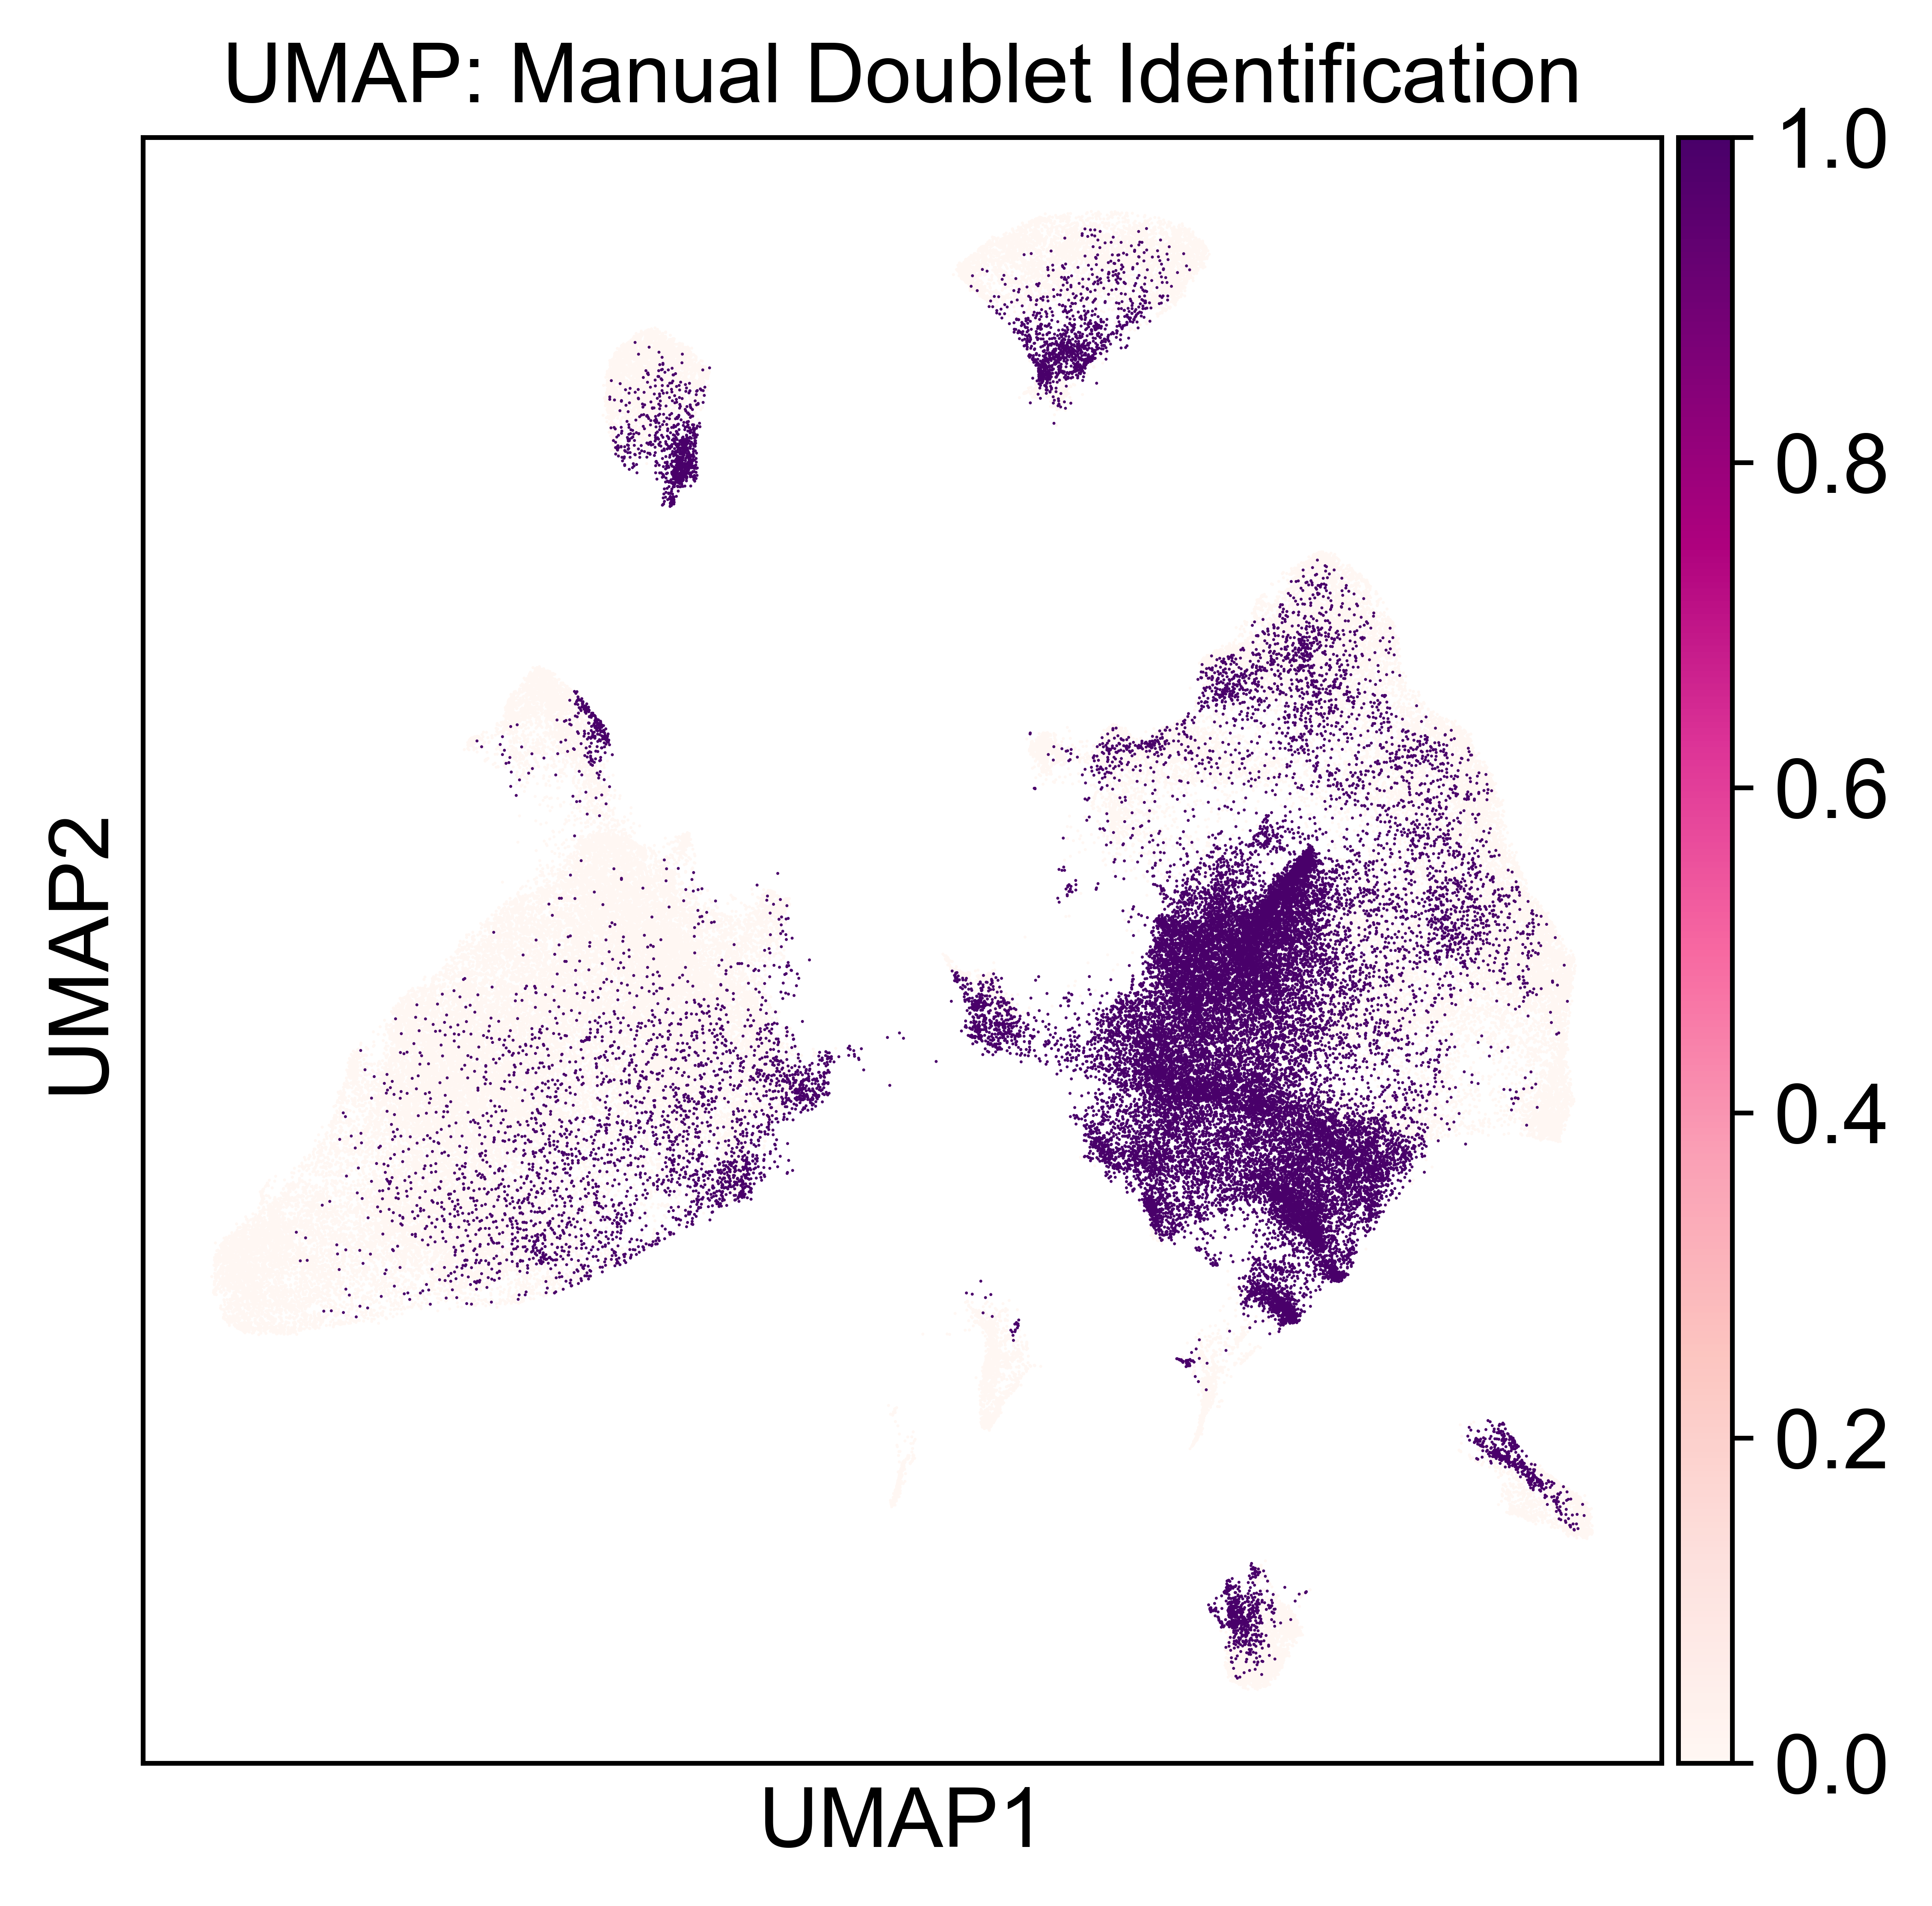

In [25]:
#granulomas a are messy w/ lots of unhappy cells
#number of doublets/multiplets in line with Gideon et al. Immunity (2022) and Winchell C, Nqyquist S.K., Journal Exp Med (2023)
adata.obs['Doublet_int'] = adata.obs['Doublet'].astype(int)
custom_palette = {1: 'black', 0: 'grey'} 
fig, ax = plt.subplots(figsize=(5,5))
sc.pl.umap(adata, color='Doublet_int', palette=custom_palette, size=1, ax=ax, show=False,title="UMAP: Manual Doublet Identification")
plt.savefig('.UMAP_Manual_doublet_identification.png',bbox_inches="tight",transparent=True)
plt.show()


filtered the doublets

In [27]:
adata_filtered = adata[adata.obs['Doublet'] == False, :]
adata_filtered

View of AnnData object with n_obs × n_vars = 88360 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'Doublet_colors_colors', 'Doublet_str_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# 2. Re-cluster data post-doublet removal 

In [28]:
adata=adata_filtered
adata = sc.AnnData(adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)
adata.raw = adata.copy()
# keep blacklist genes from vars (they are stored in .raw so still accessible)
adata = adata[:,~adata.var['Blacklist_Genes']]
#remove 16_week data from adata (these data were not used in any analyses)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata.var['highly_variable'].value_counts()
adata

AnnData object with n_obs × n_vars = 88360 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'Doublet_colors_colors', 'Doublet_str_colors'

In [ ]:
sc.tl.pca(adata, svd_solver = 'arpack', random_state = 18,use_highly_variable=True)
sc.pl.pca(adata, components=['1,2', '3,4'], color=['Group',"CD3D",'CD8A',"SFTPB","AGER","DCN","CSF1R"],
          ncols=4, use_raw=True)
sc.pl.pca_loadings(adata, components=[1,2,3,4])
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=18, random_state = 18)
sc.tl.umap(adata, min_dist = 0.1, spread = 2, random_state = 18)
sc.pl.umap(adata, color = ["Group"])

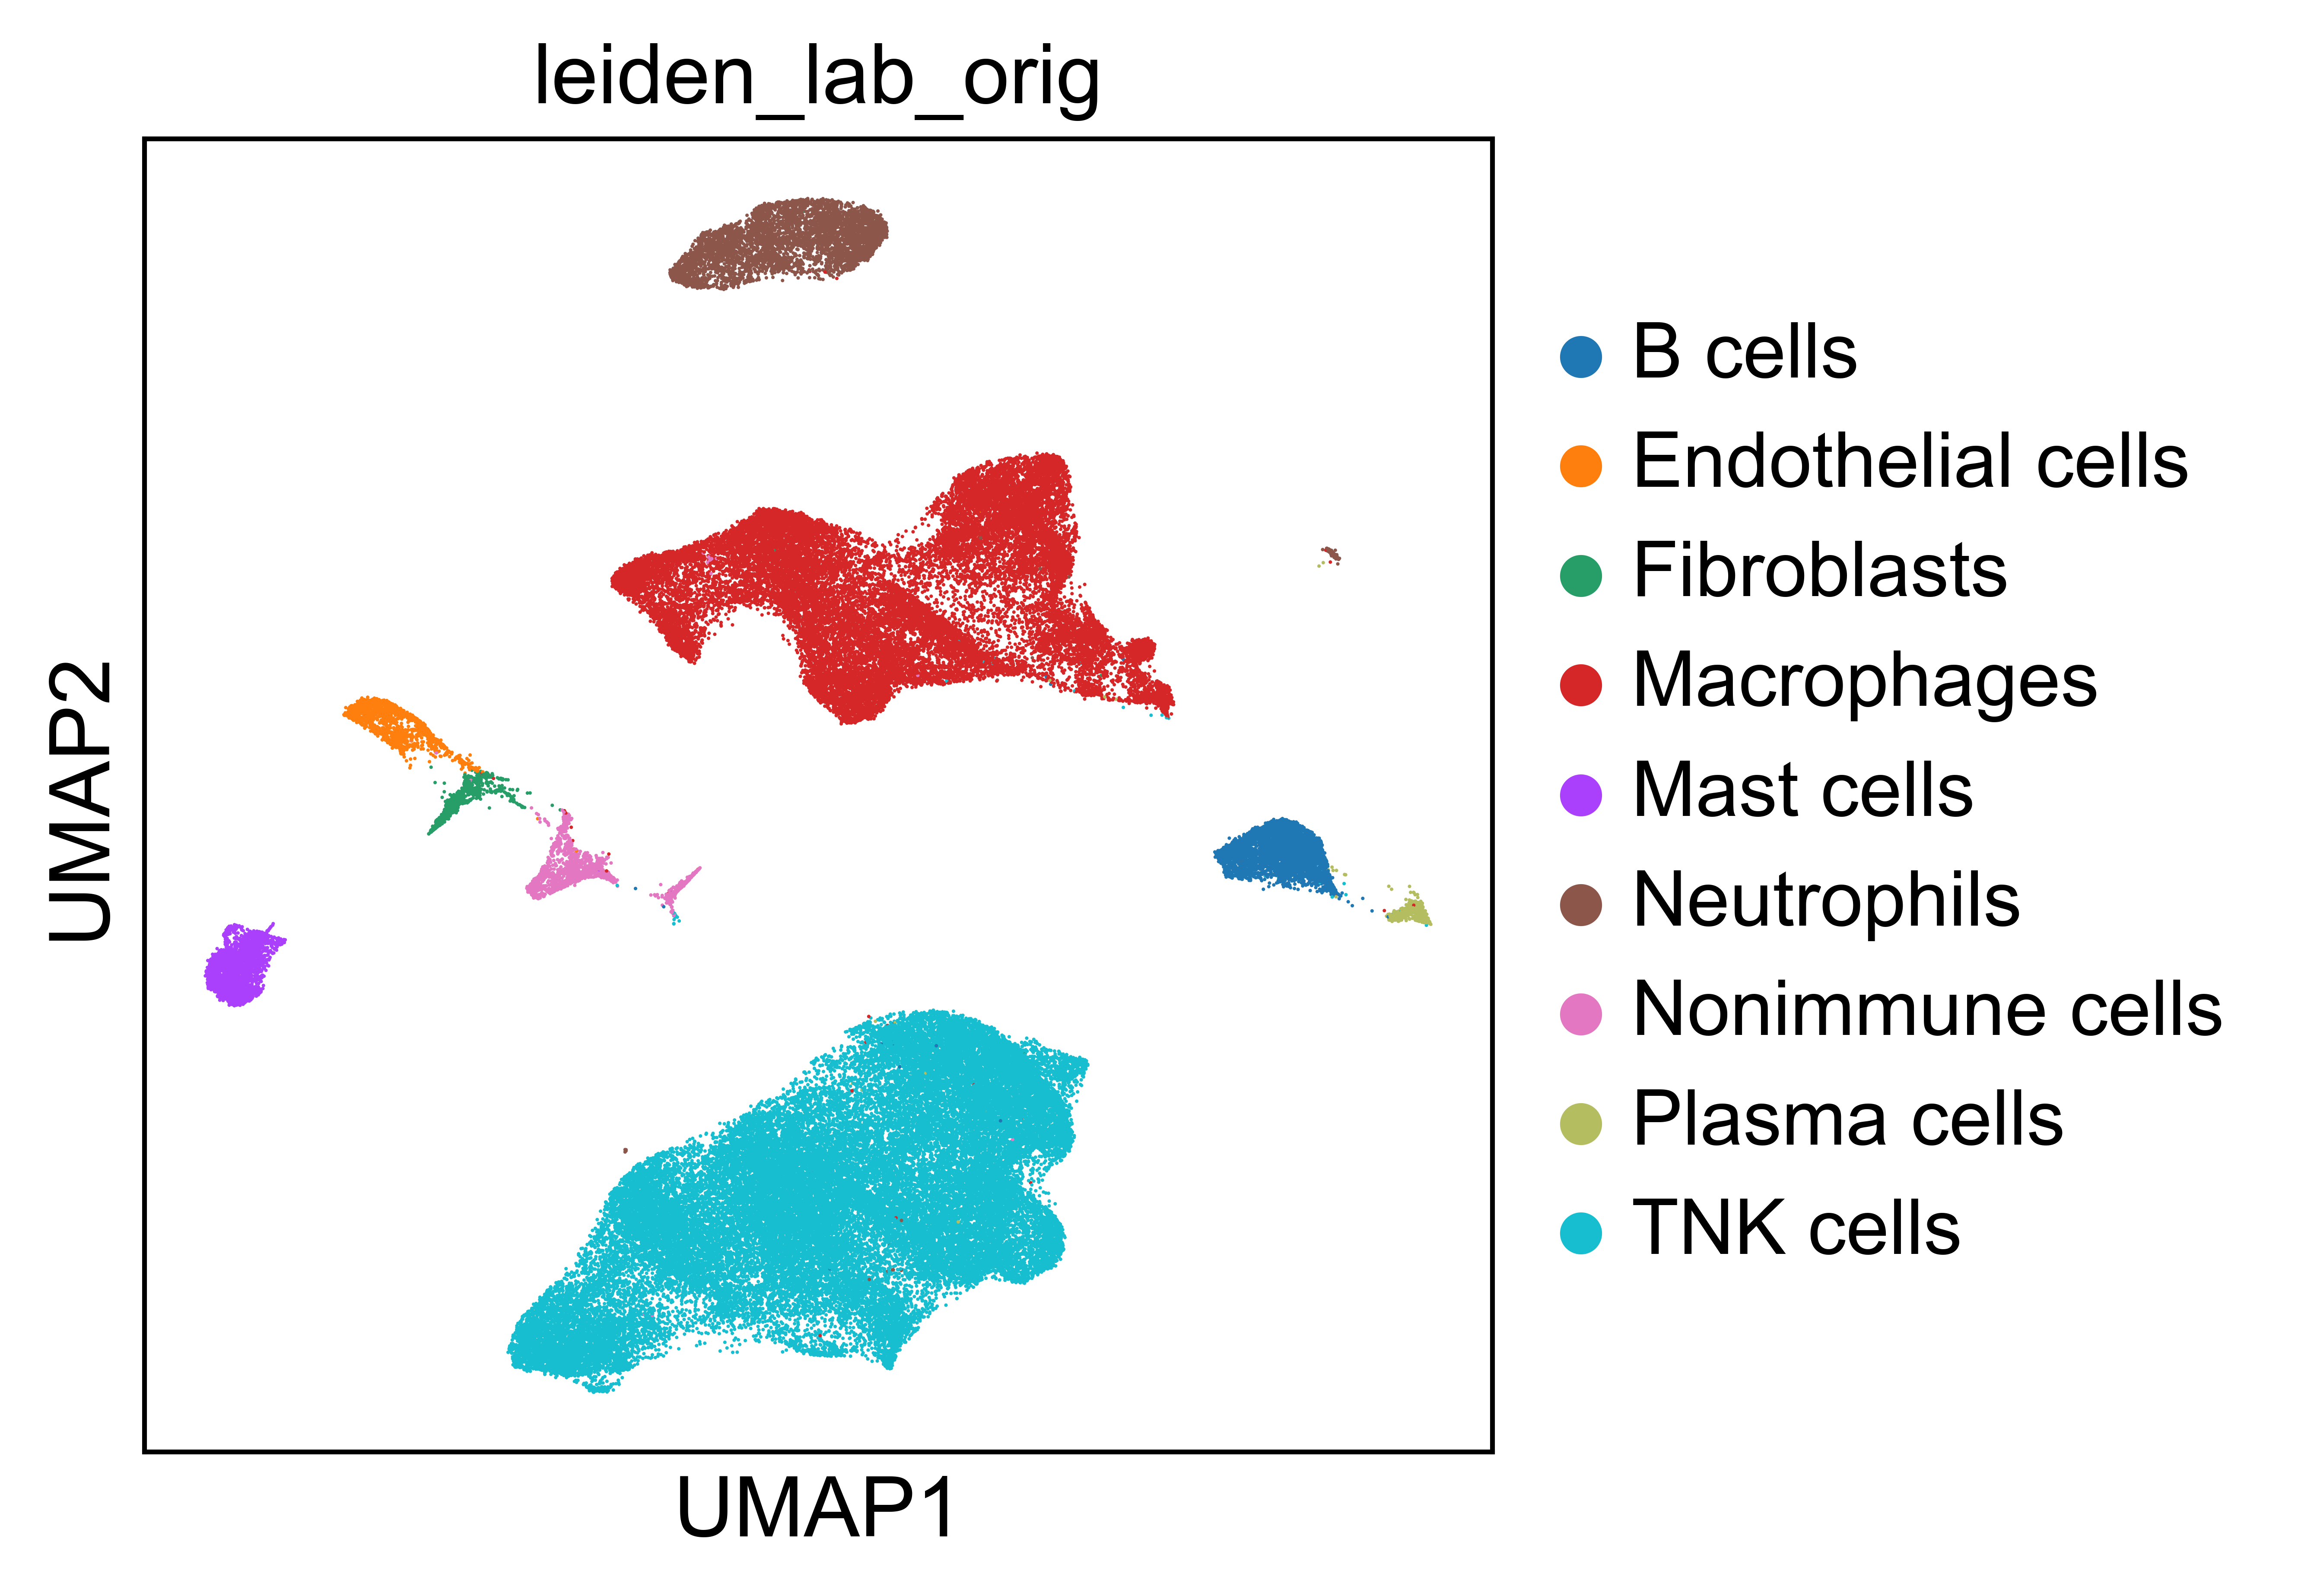

In [31]:
#sc.tl.leiden(adata,resolution=1)
sc.pl.umap(adata, color = ["leiden_lab_orig"])

In [32]:
adata.write_h5ad("./Scanpy_H5AD/adata_Final_for_Reinfection_publication.h5ad")